In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import plot_model
from keras import metrics
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


If not using GPU training will take much longer

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Pre-Processing

In [3]:
from random import sample

'''
Remove half of the images
'''

dirs = ['cell_images/Parasitized/', 'cell_images/Uninfected/']

deleted = len(os.listdir(dirs[0])) <= 6890

if not deleted:
  for fdir in dirs:
    files = os.listdir(fdir)

    for file in sample(files, int(len(files)/2)): # randomly sample half of the images
      os.remove(fdir + file)

  deleted = True
else:
  print('Already deleted half')


In [8]:
parasitized_imgs = []
parasitized_path = os.getcwd() + '/cell_images/Parasitized'
for filename in os.listdir(parasitized_path):
    if filename.split('.')[1] == 'png':
        img = cv2.imread(os.path.join(parasitized_path,filename))
        sized_img = cv2.resize(img,(224,224))
        img_arr = np.array(sized_img)
        parasitized_imgs.append(img_arr)
parasitized_imgs = np.array(parasitized_imgs)
print('Parasitized loaded...')

uninfected_imgs = []       
uninfected_path = os.getcwd() + '/cell_images/Uninfected'
for filename in os.listdir(uninfected_path):
    if filename.split('.')[1] == 'png':
        img = cv2.imread(os.path.join(uninfected_path,filename))
        sized_img = cv2.resize(img,(224,224))
        img_arr = np.array(sized_img)
        uninfected_imgs.append(img_arr)     
uninfected_imgs = np.array(uninfected_imgs)
print('Uninfected loaded...')

Parasitized loaded...
Uninfected loaded...


In [9]:
num_uninfected = np.zeros(uninfected_imgs.shape[0])
num_parasitized = np.ones(parasitized_imgs.shape[0])

x=np.concatenate((uninfected_imgs,parasitized_imgs),axis=0)
t=np.concatenate((num_uninfected,num_parasitized),axis=0)
t=t.reshape(t.shape[0],1)

Xtrain,Xtest,Ttrain,Ttest=train_test_split(x,t,test_size=0.2)
Ttrain = Ttrain.astype(int)
Ttrain = to_categorical(Ttrain)
Ttest = to_categorical(Ttest)

## Building VGG16

In [10]:
img_input = Input(shape=(224, 224, 3))

# Block 1
x = Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
x = Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
x = Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
x = Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv1')(x)
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv2')(x)
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv1')(x)
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv2')(x)
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(1000, activation='softmax', name='predictions')(x)

vggmodel = Model(input=img_input, output=x)

E:\Dev_stuff\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`


### Load pre-trained model weights

Here we load pretrained weights into the model. We only allow the training of the last 3 dense layers because
1.   Our data only has 2 classes, it would be overkill to train all the convolutional layers aswell as the dense layers. Only training the dense layers is sufficient in getting great results.
2.   Time constraints on training

#### Instructions to download


1.   Visit https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5 to download the weights file
2.   The first line of code in the cell below loads the weights from the path 'weights/vgg16...' So make sure you're weights file is in the right place





In [7]:
# load weights
vggmodel.load_weights('weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

for layers in (vggmodel.layers)[:19]: layers.trainable = False

### Clean up and compile the model

The pre-trained weights we used were from a model that used 1000 classes, so as of now our model has 1000 outputs. Since our data only has 2 classes, we modify our model to 2 outputs with sigmoid activation functions. 

We define our optimizers and loss functions as well.

In [5]:
dense_out = vggmodel.layers[-2].output
out = Dense(2, activation="sigmoid")(dense_out)

vgg_final = Model(input=vggmodel.input, output=out, name='vgg16 final')

sgd = optimizers.SGD(learning_rate=0.00001)
adm = optimizers.Adam(lr=0.001)

vgg_final.compile(optimizer=sgd, loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

NameError: name 'vggmodel' is not defined

In [9]:
vgg_final.summary()

Model: "vgg16 final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       

### Model Callbacks

Setup an early stop callback for our model. If our validation(test) accuracy does not change for 2 epochs we stop the training. We do this to prevent the model from overfitting on our training data.

In [10]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

In [40]:
import datetime
now = datetime.datetime.now()

model_history = vgg_final.fit(Xtrain, Ttrain, batch_size=64, validation_data=(Xtest, Ttest), epochs=4, verbose=1, callbacks=[early_stop])
vgg_final.save_weights('vgg16_weights_%s' % now.strftime("%m-%d"))

Train on 3785 samples, validate on 947 samples
Epoch 1/4
3785/3785 [==============================] - 4823s 1s/step - loss: 0.6253 - accuracy: 0.6880 - val_loss: 0.6081 - val_accuracy: 0.6969
Epoch 2/4
3785/3785 [==============================] - 6036s 2s/step - loss: 0.5700 - accuracy: 0.7527 - val_loss: 0.5590 - val_accuracy: 0.7730
Epoch 3/4
3785/3785 [==============================] - 4216s 1s/step - loss: 0.5259 - accuracy: 0.8029 - val_loss: 0.5192 - val_accuracy: 0.8089
Epoch 4/4
3785/3785 [==============================] - 4477s 1s/step - loss: 0.4894 - accuracy: 0.8306 - val_loss: 0.4857 - val_accuracy: 0.8321


Model Evaluation

In [41]:
model_history.history['loss']

[0.625304485674421, 0.5700471461212935, 0.52589800443643, 0.48940425287622125]

In [46]:
acc = model_history.history['accuracy']
acc

[0.68797886, 0.7527081, 0.8029062, 0.8306473]

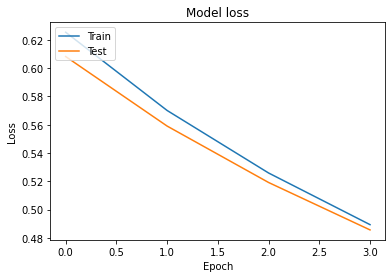

In [48]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Text(0, 0.5, 'loss')

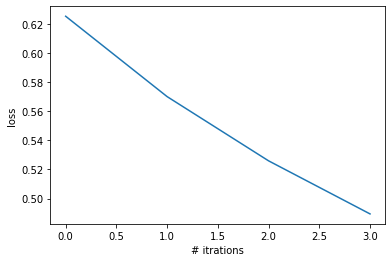

In [44]:
plt.plot(model_history.history['loss'])
plt.xlabel("# itrations")
plt.ylabel("loss")